# Tensor Network Renormalization Group for the 2D Ising model

Define the basic functions for the Ising model

Define Kronecker Delta

In [1]:
using LinearAlgebra

In [2]:
using Plots

In [3]:
function kronecker_delta(i::Int,j::Int)
    
    res = 0.
    
    if i==j
        
        res = 1.
        
    end
    
    res
    
end

kronecker_delta (generic function with 1 method)

In [4]:
kronecker_delta(1,1)

1.0

In [5]:
kronecker_delta(1,2)

0.0

Define the weight functions of Ising model

In [6]:
function weight(beta::Float64,k::Int)
    
    res = 1/2 * (exp(beta) + (-1)^k * exp(-beta))
    
    res
    
end

weight (generic function with 1 method)

In [7]:
weight(1.5,0)

2.352409615243247

Define the initial tensor

In [8]:
function init_tensor(beta::Float64)
    
    tensor = zeros(2,2,2,2)
    
    for i in 1:2, j in 1:2, k in 1:2#, l in 1:2
        
        l = mod(i+j+k-3,2)+1
        
        tensor[i,j,k,l] = sqrt(weight(beta,i-1) * weight(beta,j-1) * weight(beta,k-1) * weight(beta,l-1)) #*
            #kronecker_delta(mod(i+j+l+k,2),0)
        
    end
    
    return tensor
    
end

init_tensor (generic function with 1 method)

In [9]:
tensor = init_tensor(1.0)

2×2×2×2 Array{Float64,4}:
[:, :, 1, 1] =
 2.3811  0.0    
 0.0     1.81343

[:, :, 2, 1] =
 0.0      1.81343
 1.81343  0.0    

[:, :, 1, 2] =
 0.0      1.81343
 1.81343  0.0    

[:, :, 2, 2] =
 1.81343  0.0   
 0.0      1.3811

In [10]:
length(tensor[:,1,1,1])

2

Splitting tensors for the singular value decomposition

Define an intermediate irrep / label K for the new coarse edge, by splitting the 4-valent delta function into two three valent delta functions. This K will be the new irrep on the coarse edge.

This new label K must be kept fixed during the SVD and it determines which fine configurations contribute.

This transformation will bring the matrix M we had before into a block diagonal form, where each block is labelled by K.

Let us define some basic indices that keep track of the allowed configurations with respect to K.

In [11]:
function compute_RangeB_S_Bf()

    RangeB = zeros(Int64,2)
    S = zeros(Int64,2,2,2)
    Bf = zeros(Int64,2,2,2)

    for K in 1:2
        B = 1
        for k1 in 1:2, k2 in 1:2
            Bf[K,k1,k2] = 1
            if isodd(K + k1 + k2)

                RangeB[K] = B

                S[K,B,1] = k1
                S[K,B,2] = k2

                Bf[K,k1,k2] = B

                B += 1
            end
        end
        
    end

    return (RangeB,S,Bf)

end

compute_RangeB_S_Bf (generic function with 1 method)

In [12]:
(RangeB,S,Bf) = compute_RangeB_S_Bf();

In [13]:
RangeB

2-element Array{Int64,1}:
 2
 2

In [14]:
S

2×2×2 Array{Int64,3}:
[:, :, 1] =
 1  2
 1  2

[:, :, 2] =
 1  2
 2  1

In [15]:
Bf

2×2×2 Array{Int64,3}:
[:, :, 1] =
 1  1
 1  2

[:, :, 2] =
 1  2
 1  1

In [16]:
function compute_SVD1(tensor::Array{Float64,4})
    
    # We perform the SVD per label K.
    
    #length of tensor, we already know
    
    #len = length(tensor[:,1,1,1])
    
    S1 = zeros(2,2,2) # Here I make the choice to keep the same bond dimension
    S2 = zeros(2,2,2)
    
    Svlist = zeros(2) # I only keep one singular value per block
    
    for K in 1:2
        
        mat = zeros(RangeB[K],RangeB[K]) #B will also be the index of our matrix
        
        for B1 in 1:RangeB[K], B2 in 1:RangeB[K]
            
            # B1 -> (i,l)
            # B2 -> (j,k)
            
            (i,l) = S[K,B1,:]
            
            (j,k) = S[K,B2,:]
            
            mat[B1,B2] = tensor[i,j,k,l]
            
        end
    
        #Compute the SVD
    
        println("Compute SVD")
    
        decomp = svd(mat)
    
        U = decomp.U
        Sv = decomp.S
        V = decomp.V' # Gives us V^\dagger
        
        Svlist[K] = Sv[1] # here I make the choice to only keep the first singular value per "block"
    
        println("Print SVs")
    
        println(Sv) #prints singular values
    
        #Define the new S1 and S2
    
        for B1 in 1:RangeB[K]
            
            (i,l) = S[K,B1,:]
            
            S1[i,l,K] = U[B1,1] * sqrt(Svlist[K] / Svlist[1])
            
        end
    
        for B2 in 1:RangeB[K]
            
            (j,k) = S[K,B2,:]
            
            S2[j,k,K] = sqrt(Svlist[K] / Svlist[1]) * V[1,B2]
            
        end
        
    end
    
    return (S1,S2,Svlist / Svlist[1])
    
end    

compute_SVD1 (generic function with 1 method)

In [17]:
(S1test,S2test,Svlist1) = compute_SVD1(tensor);

Compute SVD
Print SVs
[3.7622, 1.76648e-16]
Compute SVD
Print SVs
[3.62686, 4.71028e-16]


In [18]:
function compute_SVD2(tensor::Array{Float64,4})
    
    # We perform the SVD per label K.
    
    #length of tensor, we already know
    
    #len = length(tensor[:,1,1,1])
    
    S3 = zeros(2,2,2) # Here I make the choice to keep the same bond dimension
    S4 = zeros(2,2,2)
    
    Svlist = zeros(2) # I only keep one singular value per block
    
    for K in 1:2
        
        mat = zeros(RangeB[K],RangeB[K])
        
        for B1 in 1:RangeB[K], B2 in 1:RangeB[K]
            
            #B1 -> (i,j)
            #B2 -> (k,l)
            
            (i,j) = S[K,B1,:]
            (k,l) = S[K,B2,:]
    
            mat[B1,B2] = tensor[i,j,k,l]
            
        end
        
        #Compute the SVD
    
        println("Compute SVD")
    
        decomp = svd(mat)
    
        U = decomp.U
        Sv = decomp.S
        V = decomp.V' # Gives us V^\dagger
        
        Svlist[K] = Sv[1] # here I make the choice to only keep the first singular value per "block"
    
        println("Print SVs")
    
        println(Sv) #prints singular values
    
        #Define the new S3 and S4
        
        for B1 in 1:RangeB[K]
            
            (i,j) = S[K,B1,:]    
        
            S3[i,j,K] = U[B1,1] * sqrt(Svlist[K] / Svlist[1])
            
        end
        
        for B2 in 1:RangeB[K]
            
            (k,l) = S[K,B2,:]
        
            S4[k,l,K] = sqrt(Svlist[K] / Svlist[1]) * V[1,B2]
            
        end
        
    end
    
    return (S3,S4,Svlist / Svlist[1])
    
end    

compute_SVD2 (generic function with 1 method)

In [19]:
(S3test,S4test,Svlist2) = compute_SVD2(tensor);

Compute SVD
Print SVs
[3.7622, 5.29943e-16]
Compute SVD
Print SVs
[3.62686, 0.0]


In [20]:
S3test

2×2×2 Array{Float64,3}:
[:, :, 1] =
 -0.795551   0.0     
  0.0       -0.605887

[:, :, 2] =
  0.0       -0.694272
 -0.694272   0.0     

In [21]:
Svlist2

2-element Array{Float64,1}:
 1.0               
 0.9640275800758171

In [22]:
function contract(S1::Array{Float64,3},S2::Array{Float64,3},S3::Array{Float64,3},S4::Array{Float64,3})
    
    len_coarse = length(S1[1,1,:])
    
    len_fine = length(S1[:,1,1])
    
    new_ten = zeros(len_coarse,len_coarse,len_coarse,len_coarse)
    
    for p in 1:len_coarse, q in 1:len_coarse, r in 1:len_coarse#, s in 1:len_coarse
        
        s = mod(p+q+r-3,2)+1
        
        for i in 1:len_fine#, j in 1:len_fine, k in 1:len_fine, l in 1:len_fine
        
            #new_ten[p,q,r,s] += S1[i,j,p] * S2[l,k,r] * S3[k,j,q] * S4[i,l,s]
            new_ten[p,q,r,s] += S1[i,mod(i+p-2,2)+1,p] *
            S2[mod(i+p+q+r-4,2)+1,mod(i+p+q-3,2)+1,r] *
            S3[mod(i+p+q-3,2)+1,mod(i+p-2,2)+1,q] *
            S4[i,mod(i+p+q+r-4,2)+1,s]
            
        end
        
    end
    
    return new_ten
    
end

contract (generic function with 1 method)

In [23]:
@time contract(S1test,S2test,S3test,S4test)

  0.151037 seconds (216.74 k allocations: 10.308 MiB)


2×2×2×2 Array{Float64,4}:
[:, :, 1, 1] =
 0.535325  0.0     
 0.0       0.482014

[:, :, 2, 1] =
 0.0       0.482014
 0.464675  0.0     

[:, :, 1, 2] =
 0.0       0.464675
 0.482014  0.0     

[:, :, 2, 2] =
 0.482014  0.0     
 0.0       0.464675

In [24]:
function main(beta::Float64)
    
    iter = 30 #number of iterations
    
    svlist = zeros(iter,4)
    
    tensor = init_tensor(beta)
    
    for i in 1:iter
        
        println("Iteration ", i)
        
        println("Compute first SVD")
        
        (S1,S2,sv1) = compute_SVD1(tensor);
        
        println("Compute second SVD")
        
        (S3,S4,sv2) = compute_SVD2(tensor);
        
        svlist[i,1] = i
        svlist[i,2] = sv1[2]
        #svlist[i,3] = sv1[3]
        #svlist[i,4] = sv1[4]
        
        println("Compute new tensor")
        
        tensor = contract(S1,S2,S3,S4)
        
        println()
        
    end
    
    return svlist
    
end

main (generic function with 1 method)

In [25]:
res0_38 = main(0.38);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.30297, 2.60923e-17]
Compute SVD
Print SVs
[0.835305, 0.0]
Compute second SVD
Compute SVD
Print SVs
[1.30297, 2.60923e-17]
Compute SVD
Print SVs
[0.835305, 3.92523e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.935294, 0.0647057]
Compute SVD
Print SVs
[0.526028, 0.115049]
Compute second SVD
Compute SVD
Print SVs
[0.935294, 0.0647057]
Compute SVD
Print SVs
[0.526028, 0.115049]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.844155, 0.0428819]
Compute SVD
Print SVs
[0.488285, 0.0741349]
Compute second SVD
Compute SVD
Print SVs
[0.844155, 0.0428819]
Compute SVD
Print SVs
[0.488285, 0.0741349]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.872306, 0.0486475]
Compute SVD
Print SVs
[0.492218, 0.0862127]
Compute second SVD
Compute SVD
Print SVs
[0.872306, 0.0486475]
Compute SVD
Print SVs
[0.492218, 0.0862127]
Compute new tensor

Iteration 5
Compute firs

In [26]:
res0_39 = main(0.39);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.31994, 5.20387e-17]
Compute SVD
Print SVs
[0.861533, 0.0]
Compute second SVD
Compute SVD
Print SVs
[1.31994, 5.20387e-17]
Compute SVD
Print SVs
[0.861533, 0.0]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.93459, 0.0654105]
Compute SVD
Print SVs
[0.539366, 0.11334]
Compute second SVD
Compute SVD
Print SVs
[0.93459, 0.0654105]
Compute SVD
Print SVs
[0.539366, 0.11334]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.841417, 0.0431539]
Compute SVD
Print SVs
[0.505249, 0.0718664]
Compute second SVD
Compute SVD
Print SVs
[0.841417, 0.0431539]
Compute SVD
Print SVs
[0.505249, 0.0718664]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.869459, 0.0494871]
Compute SVD
Print SVs
[0.517298, 0.0831764]
Compute second SVD
Compute SVD
Print SVs
[0.869459, 0.0494871]
Compute SVD
Print SVs
[0.517298, 0.0831764]
Compute new tensor

Iteration 5
Compute first SVD
Comput

In [27]:
res0_381 = main(0.381);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.30464, 0.0]
Compute SVD
Print SVs
[0.837913, 0.0]
Compute second SVD
Compute SVD
Print SVs
[1.30464, 0.0]
Compute SVD
Print SVs
[0.837913, 0.0]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.935218, 0.0647822]
Compute SVD
Print SVs
[0.527372, 0.114882]
Compute second SVD
Compute SVD
Print SVs
[0.935218, 0.0647822]
Compute SVD
Print SVs
[0.527372, 0.114882]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.843862, 0.0429175]
Compute SVD
Print SVs
[0.48999, 0.0739127]
Compute second SVD
Compute SVD
Print SVs
[0.843862, 0.0429175]
Compute SVD
Print SVs
[0.48999, 0.0739127]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.871988, 0.0487489]
Compute SVD
Print SVs
[0.494729, 0.0859228]
Compute second SVD
Compute SVD
Print SVs
[0.871988, 0.0487489]
Compute SVD
Print SVs
[0.494729, 0.0859228]
Compute new tensor

Iteration 5
Compute first SVD
Compute SVD
Print SV

In [28]:
res0_382 = main(0.382);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.30632, 5.21555e-17]
Compute SVD
Print SVs
[0.840523, 3.92523e-17]
Compute second SVD
Compute SVD
Print SVs
[1.30632, 2.60777e-17]
Compute SVD
Print SVs
[0.840523, 0.0]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.935143, 0.0648574]
Compute SVD
Print SVs
[0.528713, 0.114714]
Compute second SVD
Compute SVD
Print SVs
[0.935143, 0.0648574]
Compute SVD
Print SVs
[0.528713, 0.114714]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.843573, 0.0429512]
Compute SVD
Print SVs
[0.491693, 0.0736893]
Compute second SVD
Compute SVD
Print SVs
[0.843573, 0.0429512]
Compute SVD
Print SVs
[0.491693, 0.0736893]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.871678, 0.0488466]
Compute SVD
Print SVs
[0.497239, 0.0856298]
Compute second SVD
Compute SVD
Print SVs
[0.871678, 0.0488466]
Compute SVD
Print SVs
[0.497239, 0.0856298]
Compute new tensor

Iteration 5
Compute firs

In [29]:
res0_383 = main(0.383);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.30801, 0.0]
Compute SVD
Print SVs
[0.843138, 0.0]
Compute second SVD
Compute SVD
Print SVs
[1.30801, 0.0]
Compute SVD
Print SVs
[0.843138, 0.0]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.935069, 0.0649313]
Compute SVD
Print SVs
[0.530052, 0.114546]
Compute second SVD
Compute SVD
Print SVs
[0.935069, 0.0649313]
Compute SVD
Print SVs
[0.530052, 0.114546]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.843289, 0.0429831]
Compute SVD
Print SVs
[0.493394, 0.073465]
Compute second SVD
Compute SVD
Print SVs
[0.843289, 0.0429831]
Compute SVD
Print SVs
[0.493394, 0.073465]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.871374, 0.0489403]
Compute SVD
Print SVs
[0.499749, 0.0853336]
Compute second SVD
Compute SVD
Print SVs
[0.871374, 0.0489403]
Compute SVD
Print SVs
[0.499749, 0.0853336]
Compute new tensor

Iteration 5
Compute first SVD
Compute SVD
Print SV

In [30]:
res0_384 = main(0.384);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.3097, 2.60632e-17]
Compute SVD
Print SVs
[0.845756, 7.85046e-17]
Compute second SVD
Compute SVD
Print SVs
[1.3097, 2.60632e-17]
Compute SVD
Print SVs
[0.845756, 3.92523e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.934996, 0.0650038]
Compute SVD
Print SVs
[0.531389, 0.114376]
Compute second SVD
Compute SVD
Print SVs
[0.934996, 0.0650038]
Compute SVD
Print SVs
[0.531389, 0.114376]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.843009, 0.043013]
Compute SVD
Print SVs
[0.495093, 0.0732396]
Compute second SVD
Compute SVD
Print SVs
[0.843009, 0.043013]
Compute SVD
Print SVs
[0.495093, 0.0732396]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.871078, 0.0490302]
Compute SVD
Print SVs
[0.502258, 0.0850344]
Compute second SVD
Compute SVD
Print SVs
[0.871078, 0.0490302]
Compute SVD
Print SVs
[0.502258, 0.0850344]
Compute new tensor

Iteration 5
Compute 

In [31]:
res0_385 = main(0.385);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.31139, 2.60559e-17]
Compute SVD
Print SVs
[0.848377, 7.85046e-17]
Compute second SVD
Compute SVD
Print SVs
[1.31139, 2.60559e-17]
Compute SVD
Print SVs
[0.848377, 7.85046e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.934925, 0.0650749]
Compute SVD
Print SVs
[0.532724, 0.114206]
Compute second SVD
Compute SVD
Print SVs
[0.934925, 0.0650749]
Compute SVD
Print SVs
[0.532724, 0.114206]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.842733, 0.0430412]
Compute SVD
Print SVs
[0.49679, 0.0730132]
Compute second SVD
Compute SVD
Print SVs
[0.842733, 0.0430412]
Compute SVD
Print SVs
[0.49679, 0.0730132]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.87079, 0.0491162]
Compute SVD
Print SVs
[0.504767, 0.084732]
Compute second SVD
Compute SVD
Print SVs
[0.87079, 0.0491162]
Compute SVD
Print SVs
[0.504767, 0.084732]
Compute new tensor

Iteration 5
Compute fi

In [32]:
res0_386 = main(0.386);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.31309, 0.0]
Compute SVD
Print SVs
[0.851001, 7.85046e-17]
Compute second SVD
Compute SVD
Print SVs
[1.31309, 0.0]
Compute SVD
Print SVs
[0.851001, 3.92523e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.934855, 0.0651447]
Compute SVD
Print SVs
[0.534056, 0.114035]
Compute second SVD
Compute SVD
Print SVs
[0.934855, 0.0651447]
Compute SVD
Print SVs
[0.534056, 0.114035]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.842462, 0.0430674]
Compute SVD
Print SVs
[0.498486, 0.0727857]
Compute second SVD
Compute SVD
Print SVs
[0.842462, 0.0430674]
Compute SVD
Print SVs
[0.498486, 0.0727857]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.870509, 0.0491983]
Compute SVD
Print SVs
[0.507275, 0.0844267]
Compute second SVD
Compute SVD
Print SVs
[0.870509, 0.0491983]
Compute SVD
Print SVs
[0.507275, 0.0844267]
Compute new tensor

Iteration 5
Compute first SVD
Co

In [33]:
res0_387 = main(0.387);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.31479, 0.0]
Compute SVD
Print SVs
[0.853629, 3.92523e-17]
Compute second SVD
Compute SVD
Print SVs
[1.31479, 0.0]
Compute SVD
Print SVs
[0.853629, 3.92523e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.934787, 0.0652132]
Compute SVD
Print SVs
[0.535387, 0.113862]
Compute second SVD
Compute SVD
Print SVs
[0.934787, 0.0652132]
Compute SVD
Print SVs
[0.535387, 0.113862]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.842194, 0.0430918]
Compute SVD
Print SVs
[0.50018, 0.0725573]
Compute second SVD
Compute SVD
Print SVs
[0.842194, 0.0430918]
Compute SVD
Print SVs
[0.50018, 0.0725573]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.870235, 0.0492765]
Compute SVD
Print SVs
[0.509782, 0.0841185]
Compute second SVD
Compute SVD
Print SVs
[0.870235, 0.0492765]
Compute SVD
Print SVs
[0.509782, 0.0841185]
Compute new tensor

Iteration 5
Compute first SVD
Comp

In [34]:
res0_388 = main(0.388);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.3165, 2.6034e-17]
Compute SVD
Print SVs
[0.85626, 7.85046e-17]
Compute second SVD
Compute SVD
Print SVs
[1.3165, 2.6034e-17]
Compute SVD
Print SVs
[0.85626, 7.85046e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.93472, 0.0652803]
Compute SVD
Print SVs
[0.536716, 0.113689]
Compute second SVD
Compute SVD
Print SVs
[0.93472, 0.0652803]
Compute SVD
Print SVs
[0.536716, 0.113689]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.841931, 0.0431144]
Compute SVD
Print SVs
[0.501872, 0.072328]
Compute second SVD
Compute SVD
Print SVs
[0.841931, 0.0431144]
Compute SVD
Print SVs
[0.501872, 0.072328]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.869969, 0.0493506]
Compute SVD
Print SVs
[0.512289, 0.0838073]
Compute second SVD
Compute SVD
Print SVs
[0.869969, 0.0493506]
Compute SVD
Print SVs
[0.512289, 0.0838073]
Compute new tensor

Iteration 5
Compute first 

In [35]:
res0_389 = main(0.389);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.31822, 0.0]
Compute SVD
Print SVs
[0.858895, 3.92523e-17]
Compute second SVD
Compute SVD
Print SVs
[1.31822, 0.0]
Compute SVD
Print SVs
[0.858895, 3.92523e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.934654, 0.0653461]
Compute SVD
Print SVs
[0.538042, 0.113515]
Compute second SVD
Compute SVD
Print SVs
[0.934654, 0.0653461]
Compute SVD
Print SVs
[0.538042, 0.113515]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.841672, 0.0431351]
Compute SVD
Print SVs
[0.503561, 0.0720977]
Compute second SVD
Compute SVD
Print SVs
[0.841672, 0.0431351]
Compute SVD
Print SVs
[0.503561, 0.0720977]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.86971, 0.0494209]
Compute SVD
Print SVs
[0.514794, 0.0834933]
Compute second SVD
Compute SVD
Print SVs
[0.86971, 0.0494209]
Compute SVD
Print SVs
[0.514794, 0.0834933]
Compute new tensor

Iteration 5
Compute first SVD
Comp

In [36]:
@time main(0.389);

Iteration 1
Compute first SVD
Compute SVD
Print SVs
[1.31822, 0.0]
Compute SVD
Print SVs
[0.858895, 3.92523e-17]
Compute second SVD
Compute SVD
Print SVs
[1.31822, 0.0]
Compute SVD
Print SVs
[0.858895, 3.92523e-17]
Compute new tensor

Iteration 2
Compute first SVD
Compute SVD
Print SVs
[0.934654, 0.0653461]
Compute SVD
Print SVs
[0.538042, 0.113515]
Compute second SVD
Compute SVD
Print SVs
[0.934654, 0.0653461]
Compute SVD
Print SVs
[0.538042, 0.113515]
Compute new tensor

Iteration 3
Compute first SVD
Compute SVD
Print SVs
[0.841672, 0.0431351]
Compute SVD
Print SVs
[0.503561, 0.0720977]
Compute second SVD
Compute SVD
Print SVs
[0.841672, 0.0431351]
Compute SVD
Print SVs
[0.503561, 0.0720977]
Compute new tensor

Iteration 4
Compute first SVD
Compute SVD
Print SVs
[0.86971, 0.0494209]
Compute SVD
Print SVs
[0.514794, 0.0834933]
Compute second SVD
Compute SVD
Print SVs
[0.86971, 0.0494209]
Compute SVD
Print SVs
[0.514794, 0.0834933]
Compute new tensor

Iteration 5
Compute first SVD
Comp

In [37]:
y = [res0_38[:,2],res0_381[:,2],res0_382[:,2],res0_383[:,2],res0_384[:,2],
    res0_385[:,2],res0_386[:,2],res0_387[:,2],res0_388[:,2],res0_389[:,2],res0_39[:,2]]

11-element Array{Array{Float64,1},1}:
 [0.641077, 0.56242, 0.578431, 0.564273, 0.55457, 0.53805, 0.515736, 0.48475, 0.443015, 0.388859  …  0.00140255, 0.000703236, 0.000352251, 0.000301311, 0.000208521, 3.2873e-7, 3.56275e-13, 8.25741e-10, 2.24649e-11, 8.4163e-25]    
 [0.642253, 0.563902, 0.580652, 0.567357, 0.558954, 0.5442, 0.524311, 0.496515, 0.458736, 0.408942  …  0.00177802, 0.000892153, 0.000446873, 0.000238757, 0.000248637, 1.83392e-5, 3.50497e-12, 5.94049e-12, 1.56916e-10, 6.02318e-17]
 [0.643427, 0.565382, 0.582869, 0.570439, 0.56334, 0.550365, 0.532938, 0.508432, 0.474844, 0.429915  …  0.00232625, 0.0011685, 0.00058561, 0.000294803, 0.000281955, 2.31804e-7, 6.1861e-8, 6.03979e-7, 2.53106e-10, 1.7579e-26]      
 [0.644597, 0.566859, 0.585082, 0.573518, 0.567727, 0.556543, 0.541614, 0.520488, 0.491314, 0.45175  …  0.00317181, 0.00159587, 0.000800471, 0.000400942, 0.000298186, 0.000237573, 4.78389e-7, 1.56273e-12, 2.1313e-9, 5.67708e-11]  
 [0.645765, 0.568332, 0.587292, 0.5765

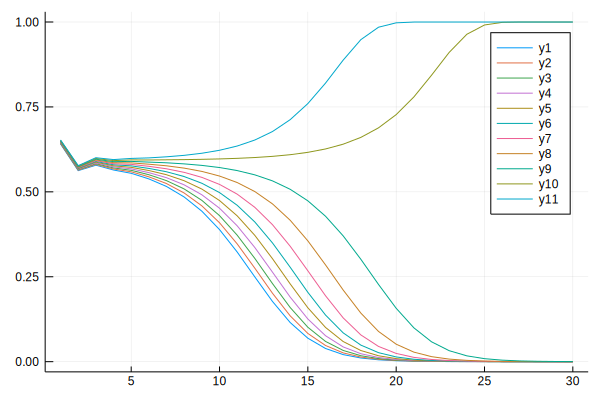

In [38]:
plot(res0_39[:,1],y)